<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CUDA-2D-Raycaster-for-Point-Clouds" data-toc-modified-id="CUDA-2D-Raycaster-for-Point-Clouds-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CUDA 2D Raycaster for Point Clouds</a></span><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Set up</a></span></li><li><span><a href="#CPU" data-toc-modified-id="CPU-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>CPU</a></span></li><li><span><a href="#GPU-/-CUDA-kernel---V1" data-toc-modified-id="GPU-/-CUDA-kernel---V1-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>GPU / CUDA kernel - V1</a></span></li></ul></li><li><span><a href="#Archive" data-toc-modified-id="Archive-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><em>Archive</em></a></span><ul class="toc-item"><li><span><a href="#Version-3---Even-more-brute-force,-too-much-I-guess" data-toc-modified-id="Version-3---Even-more-brute-force,-too-much-I-guess-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Version 3 - Even more brute force, too much I guess</a></span></li><li><span><a href="#Gen-logpdf-eval" data-toc-modified-id="Gen-logpdf-eval-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Gen logpdf eval</a></span></li><li><span><a href="#mvnormal" data-toc-modified-id="mvnormal-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span><code>mvnormal</code></a></span></li><li><span><a href="#diagnormal" data-toc-modified-id="diagnormal-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span><code>diagnormal</code></a></span></li><li><span><a href="#Version-1" data-toc-modified-id="Version-1-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Version 1</a></span></li></ul></li></ul></div>

# CUDA 2D Raycaster for Point Clouds

In [16]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [3]:
#nbx --fname="src/cuda_raycaster_point_cloud_b.jl"
push!(LOAD_PATH, "src");
using MyUtils
using CUDA
using BenchmarkTools
using Colors, Plots
col = palette(:default);

## Set up

In [4]:
n     = 2_048 # Number of poses
num_a = 361   # number of ray angles (same as in CSAIL data) 
fov   = π     # smae as in CSAIL data
a     = collect(range(0, fov, num_a)) .- fov/2 ;
zmax  = 100   # max depth measurement

cell_rad = 0.005 # Cell radius

# Sample poses
x     = rand(n,2)
hd    = rand(n)*2π; hd[1:3] = range(0, π/2, 3);
p     = hcat(x,hd)

# "Empty" measurements for each pose
z = ones(n, num_a)*zmax;

(6000, 2)

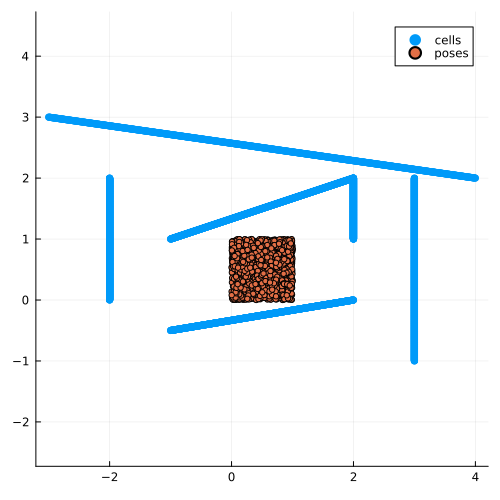

In [5]:
# Create an example grid map
y1 = [(1-t).*[-1;1] + t.*[2;2] for t=range(0,1,1_000)]
y2 = [(1-t)*[2;2] + t*[2;1] for t=range(0,1,1_000)]
y3 = [(1-t)*[-1;-0.5] + t*[2;0] for t=range(0,1,1_000)]
y4 = [(1-t)*[3;-1] + t*[3;2] for t=range(0,1,1_000)]
y5 = [(1-t)*[-2,0] + t*[-2;2] for t=range(0,1,1_000)]
y6 = [(1-t)*[-3,3] + t*[4;2] for t=range(0,1,1_000)]

y = stack([y1;y2;y3;y4;y5;y6]);
m = size(y,1) # Number of cells

print(size(y))
# ---------------------------
plot(size=(500,500), aspect_ratio=:equal)
scatter!(y[:,1],y[:,2], markerstrokewidth=0.0, label="cells")
scatter!(x[:,1],x[:,2], markersize=3, label="poses")

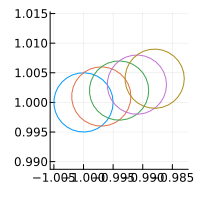

In [6]:
# Check cell resolution
# ----------------------
myplot = plot(size=(200,200), aspect_ratio=:equal)
for i = 1:5
    cxs = stack([[cell_rad*cos(θ) + y[i,1];cell_rad*sin(θ) + y[i,2]] for θ=range(0,2π, 30)])
    plot!(cxs[:,1],cxs[:,2], label=nothing)
end
myplot

## CPU



**General Idea**

For each cell we compute which rays are (potentially) affected and
fill in the distance to the cell center.
This gives a runtime of `O(|cells|)`.

We do this using a quantization function mapping angles to sensor indices as follows:
```julia
k(a; res) = Int(floor(a/res)) + 1
```
For an array `as  = range(0,fov, n)`
and `res = as[2] - as[1]` 
it maps `a` to `k` such that 
```julia
as[k] <= a < as[k+1].
``` 

In [7]:
#nbx
function cast_cpu!(z, y, x, hd, fov, cell_rad)
    
    num_bins = size(z,2)
    bin_res = fov/(num_bins - 1)

    for i = 1:1:size(x,1), j = 1:1:size(y,1)
        d1 = y[j,1] - x[i,1]
        d2 = y[j,2] - x[i,2]
        
        # Any ray that intersect our cell
        # will be assigned this value
        v  = sqrt(d1^2 + d2^2)
        
        a′ = atan(d2,d1) - hd[i] + fov/2
        a′ = mod(a′, 2π) 
        
        # Angular resolution of cell y
        da = atan(cell_rad/sqrt(v^2 - min(v, cell_rad)^2));
        a1 = a′ - da;
        a2 = a′ + da;
        
        k1 = Int(floor(a1/bin_res)) + 1
        k2 = Int(floor(a2/bin_res)) + 1
        
        # We start to the right of ray `k1` and
        # at each step we crossed ray `k` and 
        # fill in the respective depth value `v`.
        for k = k1+1:k2
            # Todo: Resolve crossing two pi
            if 1 <= k && k <= num_bins
                @inbounds z[i,k] = min(z[i,k], v)
            end
        end
    end
    return
end

function bench_cast_cpu!(z, y, x, hd, fov, cell_res)
    cast_slow!(z, y, x, hd, fov, cell_res)
end

bench_cast_cpu! (generic function with 1 method)

In [8]:
z = ones(n, num_a)*zmax;
cast_cpu!(z, y, x, hd, fov, cell_rad)

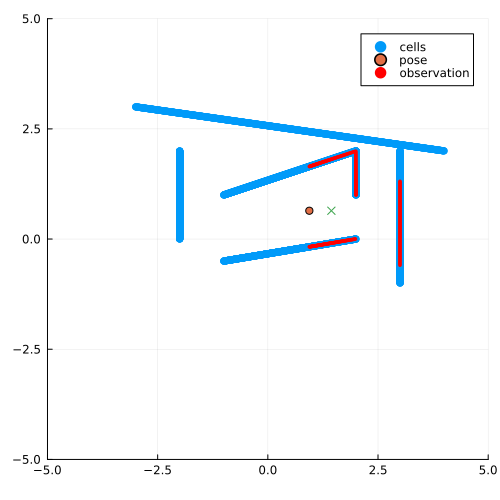

In [9]:
i = 1
v = stack(polar_inv(z[i,:], a .+ hd[i]) .+ [x[i,:]]);
# ------------
plot(size=(500,500), aspect_ratio=:equal, xlim=(-5,5), ylim=(-5,5))
scatter!(y[:,1],y[:,2], markerstrokewidth=0.0, label="cells", c=col[1])
scatter!([x[i,1]],[x[i,2]], label="pose")
scatter!([x[i,1] + 0.5*cos(hd[i])],[x[i,2] + 0.5*sin(hd[i])], label=nothing, marker=:x)
scatter!(v[:,1], v[:,2], markersize=2, markerstrokewidth=0.0, c=:red,  label="observation")

## GPU / CUDA kernel - V1 

In [13]:
#nbx
"""
    griddims = cuda_grid(datadims::Tuple{Vararg{Int}}, 
                         blockdims::Tuple{Vararg{Int}})

Given data dimensions `datadims` and number of threads 
in each dimension `blockdims` returns the respective 
grid dimensions `griddims` such that

    griddims[i] = ceil(Int, datadims[i]/blockdims[i])

"""
function cuda_grid(datadims::Tuple{Vararg{Int}}, blockdims::Tuple{Vararg{Int}})
    griddims = ceil.(Int, datadims./blockdims)
    return griddims
end

cuda_grid

In [15]:
#nbx
"""
    cast_kernel!(z, y, x, hd, fov, cell_rad)

Collects `n` depth measurements in an obs array `z` of shape `(n, a)`
from `n` poses given by arrays `x` and `hd` of shape `(n,2)` and `(n,)`
and a point cloud `y` of shape `(m,2)`.
"""
function cast_kernel!(z, y, p, fov, cell_rad)
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    
    num_a = size(z,2)
    r = fov/(num_a - 1)
    
    for i = ix:sx:size(p,1), j = iy:sy:size(y,1)
        d1 = y[j,1] - p[i,1]
        d2 = y[j,2] - p[i,2]
        v  = sqrt(d1^2 + d2^2)
        a′ = atan(d2,d1) - p[i,3]
        
        # Angular resolution of cell y
        da = atan(cell_rad/sqrt(v^2 - min(v, cell_rad)^2));
        # Todo: What is a good minimal value
        da = min(da, 10*r)
        a1 = a′ - da;
        a2 = a′ + da;
        
        a1 = mod(a1 + π, 2π) - π
        a2 = mod(a2 + π, 2π) - π
        
        # Ensure a1 < a2
        if a1 > a2
            a1, a2 = a2, a1
        end
        
        # Check if we cross from `-π+a` to `π-b`
        if a2 - a1 > π
            zero = - fov/2;
            k1 = Int(floor((a2    - zero)/r))+1
            k2 = Int(floor((a1+2π - zero)/r))+1

            k1′ = Int(floor((a2-2π - zero)/r))+1
            k2′ = Int(floor((a1    - zero)/r))+1
            
            ks = ((k1,k2), (k1′,k2′))
        else
            zero = - fov/2;
            k1 = Int(floor((a1 - zero)/r))+1
            k2 = Int(floor((a2 - zero)/r))+1

            ks = ((k1,k2),)
        end
                
        for (k1,k2) in ks, k = k1+1:k2
            if 1 <= k && k <= num_a
                @inbounds CUDA.@atomic z[i,k] = min(z[i,k], v)
            end
        end
    end
    return
end

"""
    cast_cu!(z_, y_, p_; fov=π, cell_rad=0.005, blockdims=(16,16))

Collects `n` sensor scans in an obs array `z` of shape `(n, a)`
from `n` poses given by an array `p` `(n,3)` and `(n,)`
and a point cloud `y` of shape `(m,2)`.
"""
function cast_cu!(z_, y_, p_; fov=π, cell_rad=0.01, blockdims=(16,16))
    n = size(p_,1)
    m = size(y_,1)

    griddims = cuda_grid((n,m), blockdims)    
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast_kernel!(z_, y_, p_, fov, cell_rad)
    end
end;

In [34]:
z = zmax*ones(n, num_a);

y_ = CuArray(y)
p_ = CuArray(p)
z_ = CuArray(z);

println("y:$(size(y_)), p:$(size(p_))")

n = size(p_,1)
m = size(y_,1)
blockdims = (16,16)
griddims = cuda_grid((n,m), blockdims)
@cuda threads=blockdims blocks=griddims cast_kernel!(z_, y_, p_, fov, cell_rad)
@btime cast_cu!($z_, $y_, $p_; fov=$fov, cell_rad=$cell_rad) samples=4 evals=4;

y:(6000, 2), p:(2048, 3)
  996.405 μs (77 allocations: 4.39 KiB)


```julia
y:(6000, 2), p:(2048, 3)
  996.405 μs (77 allocations: 4.39 KiB)
```

In [23]:
function bench_move_to_GPU(z,y,x,hd)
    y_  = CuArray(y)
    x_  = CuArray(x)
    hd_ = CuArray(hd)
    z_  = CuArray(z);
end

println("z:$(size(z)), y:$(size(y)), x:$(size(x))")
@btime bench_move_to_GPU($z,$y,$x,$hd) samples=1 evals=1;

z:(2048, 361), y:(6000, 2), x:(2048, 2)
  874.435 μs (16 allocations: 640 bytes)


```julia
z:(2048, 361), y:(6000, 2), x:(2048, 2)
  688.380 μs (16 allocations: 640 bytes)
```

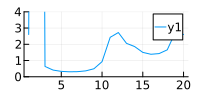

In [37]:
num_a = 20
z = ones(n, num_a)*zmax;
z_ = CuArray(z);
n1 = ceil(Int, n/16)
n2 = ceil(Int, m/16)
fov = 2π
a = collect(range(-fov/2, fov/2, num_a));

cast_cu!(z_, y_, p_; fov= fov, cell_rad=cell_rad)
z = Array(z_)

# --------------------------------
plot(size=(200,100), ylim=(0,4))
plot!(z[1,:])

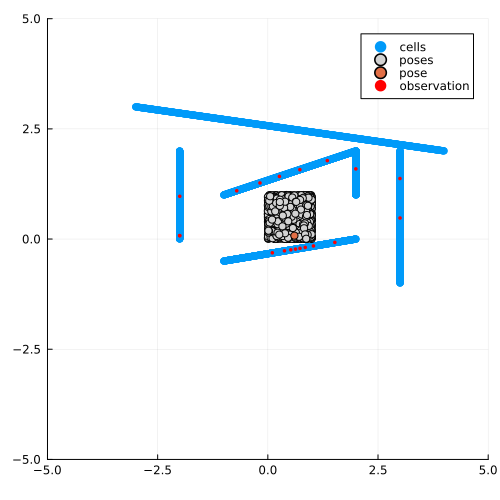

In [36]:
i = 1
v = stack(polar_inv(z[i,:], a .+ hd[i]) .+ [x[i,:]]);
# ------------
plot(size=(500,500), aspect_ratio=:equal, xlim=(-5,5), ylim=(-5,5))
scatter!(y[:,1],y[:,2], markerstrokewidth=0.0, label="cells")
scatter!(x[:,1],x[:,2], c=:lightgray, label="poses")
scatter!(x[[i],1],x[[i],2], label="pose", c=col[2])
scatter!(v[:,1], v[:,2], markersize=2, markerstrokewidth=0.0, c=:red,  label="observation")

# _Archive_

## Version 3 - Even more brute force, too much I guess

In [11]:
function cast_3!(a, z, y, x, hd, fov, cell_rad)
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
    
    
    
    for i = ix:sx:size(x,1), j = iy:sy:size(y,1), k = iz:sz:size(a,1)
        
        d1 = y[j,1] - x[i,1]
        d2 = y[j,2] - x[i,2]
        v = sqrt(d1^2 + d2^2)
        
        a1 = cos(a[k] + hd[i])
        a2 = sin(a[k] + hd[i])
        
        
        if a1*d1 + a2*d2 > 0

            # angle orthogonal to a + hd
            na = a[k] + hd[i] + π/2 
            w1 = cos(na) 
            w2 = sin(na)
            pr = w1*d1 + w2*d2
            if abs(pr) < cell_rad
                z[i,k] = min(z[i,k], v)
            end
        end
    end
    return
end

cast_3! (generic function with 1 method)

In [21]:
8*16*2

256

(256, 3000, 23)

In [27]:
function bench_cast_3!(a, z, y, x, hd, fov, cell_rad)
    n = size(x,1)
    m = size(y,1)
    num_a = size(a,1)
    n1 = ceil(Int, n/8)
    n2 = ceil(Int, m/8)
    n3 = ceil(Int, m/4)
    N = n*m*num_a
    numblocks = ceil(Int, N/256)
    
    CUDA.@sync begin
        @cuda threads=(8,8,4) blocks=numblocks cast_3!(a, z, y, x, hd, fov, cell_rad)
    end
end;

N = size(y,1)*size(x,1)*size(a,1)
numblocks = ceil(Int, N/256)

n = size(x,1)
m = size(y,1)
num_a = size(a,1)

n1 = ceil(Int, n/8)
n2 = ceil(Int, m/8)
n3 = ceil(Int, m/4)

z = ones(n, num_a)*zmax;
z_  = CuArray(z);
y_  = CuArray(y)
x_  = CuArray(x)
hd_ = CuArray(hd)

a_  = CuArray(a);


blockdims = (16,1,16)
griddims = cuda_grid((n,m,num_a), blockdims)
@cuda threads=blockdims blocks=griddims cast_3!(a_, z_, y_, x_, hd_, fov, cell_rad)

CUDA.HostKernel{typeof(cast_3!), Tuple{CuDeviceVector{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceVector{Float64, 1}, Irrational{:π}, Float64}}(cast_3!, CuFunction(Ptr{CUDA.CUfunc_st} @0x00000000098ca580, CuModule(Ptr{CUDA.CUmod_st} @0x000000000b13dc20, CuContext(0x00000000046e3bc0, instance 4234318b3f840389))), CUDA.KernelState(Ptr{Nothing} @0x00007f77abe00000))

In [28]:
size(x_), size(hd_), size(y_), size(a_)

((2048, 2), (2048,), (6000, 2), (361,))

In [30]:
z = ones(n, num_a)*zmax;
z_  = CuArray(z);

@btime bench_cast_3!(a_[1:10:end], z_[1:1,:], y_[1:200,:], x_[1:1,:], hd_[1:1], fov, cell_rad)

  262.074 μs (261 allocations: 11.75 KiB)


CUDA.HostKernel{typeof(cast_3!), Tuple{CuDeviceVector{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceVector{Float64, 1}, Irrational{:π}, Float64}}(cast_3!, CuFunction(Ptr{CUDA.CUfunc_st} @0x00000000098ca580, CuModule(Ptr{CUDA.CUmod_st} @0x000000000b13dc20, CuContext(0x00000000046e3bc0, instance 4234318b3f840389))), CUDA.KernelState(Ptr{Nothing} @0x00007f77abe00000))

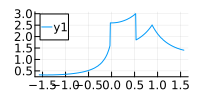

In [201]:
z = ones(n, num_a)*zmax;
z_ = CuArray(z);

@cuda threads=(8,8,4) blocks=numblocks cast_3!(a_, z_, y_, x_, hd_, fov, cell_rad)

# --------------------------------
plot(size=(200,100))
plot!(a, Array(z_)[1,:])

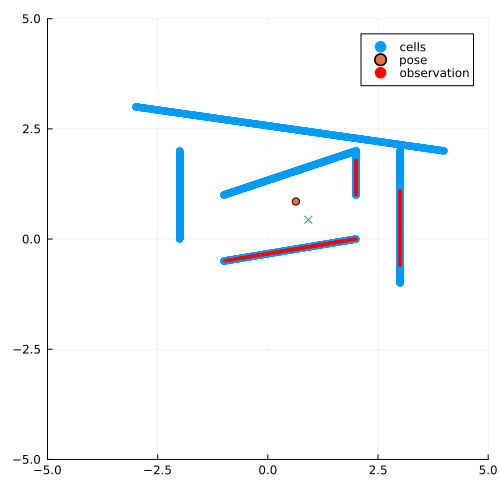

In [202]:
i = 6
v = stack(vec(Array(z_)[i,:], a .+ hd[i]) .+ [x[i,:]]);
# ------------
plot(size=(500,500), aspect_ratio=:equal, xlim=(-5,5), ylim=(-5,5))
scatter!(y[:,1],y[:,2], markerstrokewidth=0.0, label="cells", c=col[1])
scatter!([x[i,1]],[x[i,2]], label="pose")
scatter!([x[i,1] + 0.5*cos(hd[i])],[x[i,2] + 0.5*sin(hd[i])], label=nothing, marker=:x)
scatter!(v[:,1], v[:,2], markersize=2, markerstrokewidth=0.0, c=:red,  label="observation")

## Gen logpdf eval

Let's check the evaluation time of Gen's `mvnormal`

In [211]:
using Gen
using LinearAlgebra: diagm

In [212]:
m = size(y,1)
n = size(x,1)
numblocks = ceil(Int, m*n/256)


z = ones(n, num_a)*zmax;

y_  = CuArray(y)
x_  = CuArray(x)
hd_ = CuArray(hd)
z_  = CuArray(z);

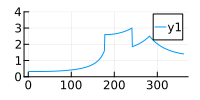

In [213]:
z = ones(n, num_a)*zmax;
z_ = CuArray(z);

@cuda threads=(16,16) blocks=numblocks cast!(z_, y_, x_, hd_, fov, cell_rad)

# --------------------------------
plot(size=(200,100), ylim=(0,4))
plot!(Array(z_)[1,:])

## `mvnormal`

In [218]:
i=1
z = Array(z_)
obs = rand(num_a)
stds = ones(num_a)
D = diagm(stds)

num_a, size(z)

(361, (2048, 361))

In [215]:
@btime mvnormal(z[i,:], D);
@btime logpdf(mvnormal, obs, z[i,:], D);

  1.487 ms (8 allocations: 1.99 MiB)
  1.552 ms (10 allocations: 2.00 MiB)


## `diagnormal`

In [219]:
struct DiagonalNormal <: Distribution{Vector{Float64}} end
const diagnormal = DiagonalNormal()

function random(::DiagonalNormal, mus::AbstractVector{U}, stds::AbstractVector{V}) where {U <: Real, V <: Real}
    return [normal(mu, std) for (mu,std) in zip(mus, stds)]
end

function random(::DiagonalNormal, mus::AbstractVector{U}, std::V) where {U <: Real, V <: Real}
    return [normal(mu, std) for mu in mus]
end

(::DiagonalNormal)(mus::AbstractVector{U}, stds::AbstractVector{V})  where {U <: Real, V <: Real} = random(DiagonalNormal(), mus, stds)
(::DiagonalNormal)(mus::AbstractVector{U}, std::V)  where {U <: Real, V <: Real} = random(DiagonalNormal(), mus, std)


function Gen.logpdf(::DiagonalNormal, xs::AbstractVector{T}, 
                mus::AbstractVector{U}, stds::AbstractVector{V}) where {T <: Real, U <: Real, V <: Real}
    log_p = 0.0
    for (x, mu, std) in zip(xs, mus, stds)
        log_p += Gen.logpdf(normal, x, mu, std)
    end
    return log_p
end

function Gen.logpdf(::DiagonalNormal, xs::AbstractVector{T}, 
                mus::AbstractVector{U}, std::V) where {T <: Real, U <: Real, V <: Real}
    log_p = 0.0
    for (x, mu) in zip(xs, mus)
        log_p += Gen.logpdf(normal, x, mu, std)
    end
    return log_p
end


has_output_grad(::DiagonalNormal) = true
has_argument_grads(::DiagonalNormal) = (true, true)

has_argument_grads (generic function with 1 method)

In [223]:
diagnormal(ones(10), collect(range(0.01,5.01,10)))

10-element Vector{Float64}:
  0.9938215277893769
  1.1055327491970943
  0.30382021312480445
  2.6823581583626783
  5.766798771516864
  2.8990787005456102
  0.07977258112483987
 -3.153906851817786
 -2.9792915745231423
  2.6003416726000284

In [224]:
i=1
z = Array(z_)
obs = rand(num_a)
stds = ones(num_a)

num_a, size(z)

(361, (2048, 361))

In [225]:
@btime diagnormal(z[i,:], stds)
@btime logpdf(diagnormal, obs, z[i,:], stds)

  5.033 μs (3 allocations: 6.02 KiB)
  5.360 μs (3 allocations: 3.03 KiB)


-631.4354902299563

## Version 1

In [33]:
function cast_old_binned!(z, y, x, hd)
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y

    res = 2π/size(z,2)
    for i = ix:sx:size(x,1), j = iy:sy:size(y,1)
        d1 = y[j,1] - x[i,1]
        d2 = y[j,2] - x[i,2]
        a = atan(d2,d1) - hd[i]
        a = mod(a + res/2, 2π) 
        v = sqrt(d1^2 + d2^2)
        k = Int(floor(a/res)) + 1
        @inbounds z[i,k] = min(z[i,k], v)
    end 
    return
end

cast_old_binned! (generic function with 1 method)

In [35]:
function bench_cast_old_binned!(z, y, x, hd)
    m = size(y,1)
    n = size(x,1)
    
#     numblocks = ceil(Int, m*n/256)
    n1 = ceil(Int, n/16)
    n2 = ceil(Int, m/16)
    
    CUDA.@sync begin
        @cuda threads=(16,16) blocks=(n1,n2) cast_old_binned!(z, y, x, hd)
    end
end;

In [36]:
m = size(y,1)
n = size(x,1)

# numblocks = ceil(Int, m*n/256)
n1 = ceil(Int, n/16)
n2 = ceil(Int, m/16)

z = ones(n, num_a)*zmax;
z_  = CuArray(z);
y_  = CuArray(y)
x_  = CuArray(x)
hd_ = CuArray(hd)


@cuda threads=(16,16) blocks=(n1,n2) cast_old_binned!(z_, y_, x_, hd_)

CUDA.HostKernel{typeof(cast_old_binned!), Tuple{CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceVector{Float64, 1}}}(cast_old_binned!, CuFunction(Ptr{CUDA.CUfunc_st} @0x000000000e8361d0, CuModule(Ptr{CUDA.CUmod_st} @0x0000000010c96150, CuContext(0x00000000054136c0, instance c4172330b0e89859))), CUDA.KernelState(Ptr{Nothing} @0x00007fa1efe00000))

In [37]:
z = ones(n, num_a)*zmax;
z_  = CuArray(z);

@btime bench_cast_old_binned!($z_, $y_, $x_, $hd_)

  537.438 μs (24 allocations: 1.44 KiB)


CUDA.HostKernel{typeof(cast_old_binned!), Tuple{CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceVector{Float64, 1}}}(cast_old_binned!, CuFunction(Ptr{CUDA.CUfunc_st} @0x000000000e8361d0, CuModule(Ptr{CUDA.CUmod_st} @0x0000000010c96150, CuContext(0x00000000054136c0, instance c4172330b0e89859))), CUDA.KernelState(Ptr{Nothing} @0x00007fa1efe00000))